trying out different image pre processing methods for iam-lines and then finally applying binarization

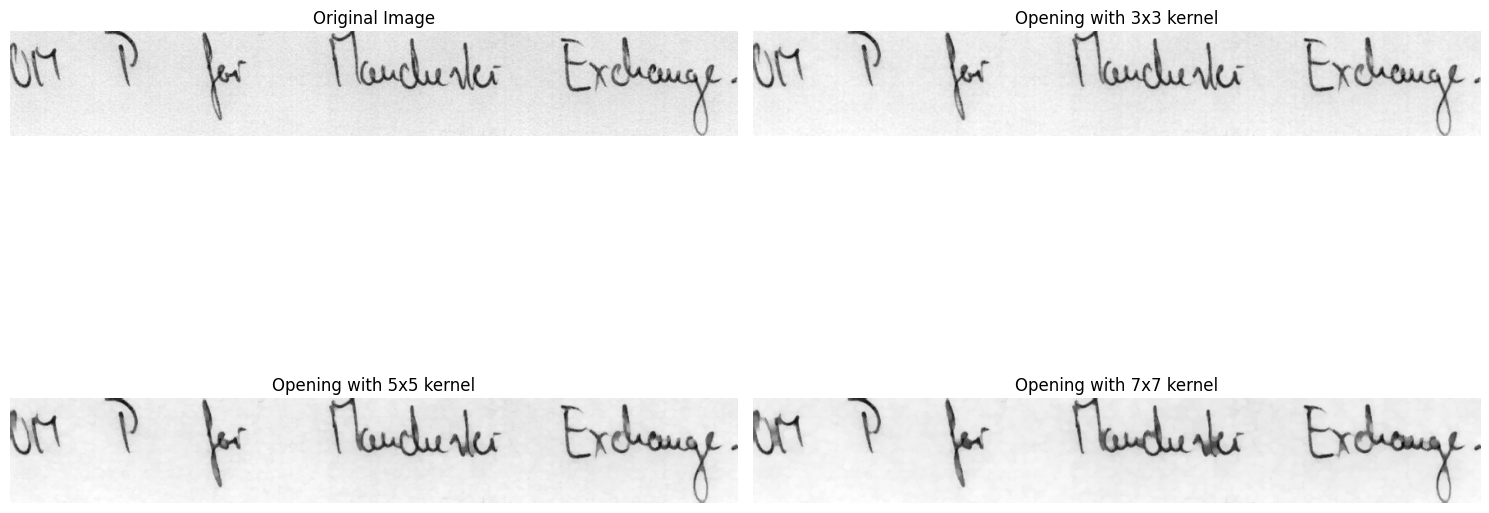

Saved result with 5x5 kernel to opened_image.png


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def apply_morphological_opening(image_path, kernel_size=5, iterations=1, save_path=None):
    """
    Apply morphological opening to an image
    
    Args:
        image_path: Path to the input image
        kernel_size: Size of the structuring element (kernel)
        iterations: Number of times to apply the opening operation
        save_path: Path to save the processed image (optional)
        
    Returns:
        The processed image
    """
    # Check if file exists
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Try different methods to read the image
    try:
        # Read with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("OpenCV couldn't read the image")
    except Exception as e:
        try:
            # Fallback to PIL
            pil_img = Image.open(image_path)
            img = np.array(pil_img)
            # Convert RGB to BGR for OpenCV if needed
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except Exception as e2:
            raise ValueError(f"Could not read image with OpenCV or PIL: {str(e)} | {str(e2)}")
    
    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    # Create the structuring element (kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Apply morphological opening
    # Opening = Erosion followed by Dilation
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=iterations)
    
    # Save the processed image if a save path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
        cv2.imwrite(save_path, opened)
    
    return opened

def display_comparison(original_img, processed_img, title1="Original", title2="After Opening"):
    """
    Display the original and processed images side by side
    """
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(title1)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(title2)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def batch_process_directory(input_dir, output_dir, kernel_size=5, iterations=1):
    """
    Process all images in a directory
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            try:
                apply_morphological_opening(input_path, kernel_size, iterations, output_path)
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Single image example
    input_path = r"C:\Users\kani1\Desktop\IE643\custom-dataset\iam-handwritten-lines\images\iam_line_0007.png"
    output_path = "opened_image.png"
    
    try:
        # Read the original image
        original = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
            # Try with PIL if OpenCV fails
            original = np.array(Image.open(input_path).convert('L'))
        
        # Apply morphological opening with different kernel sizes for comparison
        opened_small = apply_morphological_opening(input_path, kernel_size=3, iterations=1)
        opened_medium = apply_morphological_opening(input_path, kernel_size=5, iterations=1)
        opened_large = apply_morphological_opening(input_path, kernel_size=7, iterations=1)
        
        # Save the medium kernel result
        cv2.imwrite(output_path, opened_medium)
        
        # Display comparisons
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(2, 2, 2)
        plt.imshow(opened_small, cmap='gray')
        plt.title("Opening with 3x3 kernel")
        plt.axis("off")
        
        plt.subplot(2, 2, 3)
        plt.imshow(opened_medium, cmap='gray')
        plt.title("Opening with 5x5 kernel")
        plt.axis("off")
        
        plt.subplot(2, 2, 4)
        plt.imshow(opened_large, cmap='gray')
        plt.title("Opening with 7x7 kernel")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        print(f"Saved result with 5x5 kernel to {output_path}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        
    # Uncomment to process a whole directory
    # input_dir = "path/to/input/images"
    # output_dir = "path/to/output/images"
    # batch_process_directory(input_dir, output_dir, kernel_size=5, iterations=1)

C:\Users\kani1\AppData\Local\Temp\ipykernel_14068\3315372639.py:76: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(original_img.flatten(), 256, [0, 256], color='r', alpha=0.7)
C:\Users\kani1\AppData\Local\Temp\ipykernel_14068\3315372639.py:89: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(equalized_img.flatten(), 256, [0, 256], color='b', alpha=0.7)


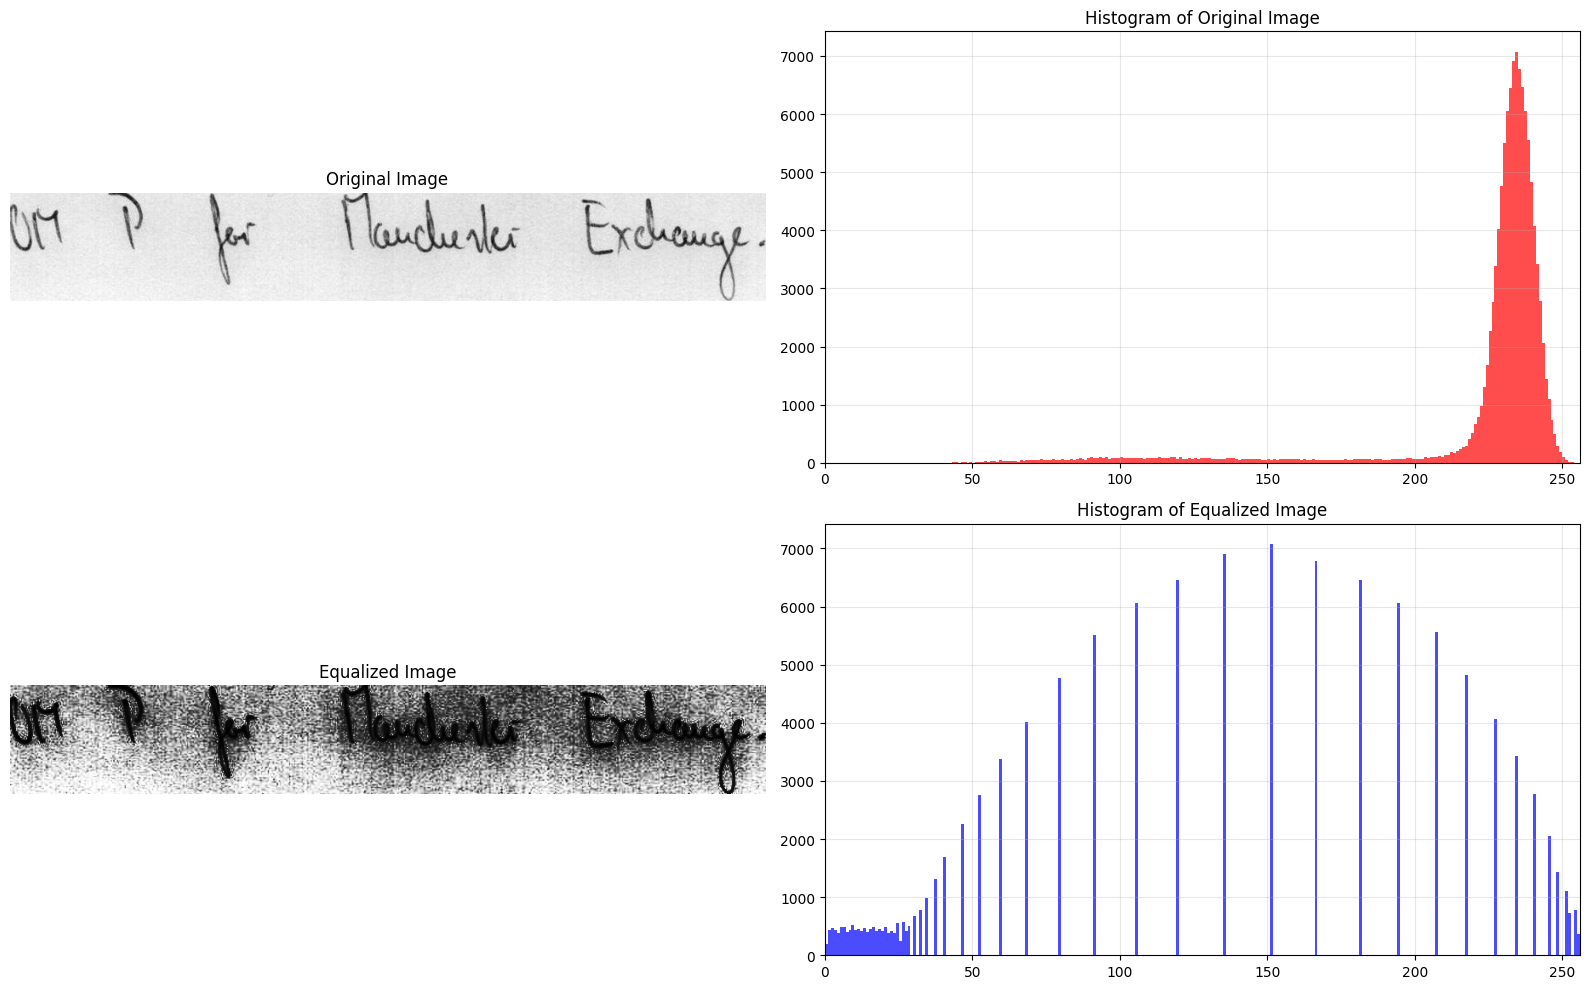

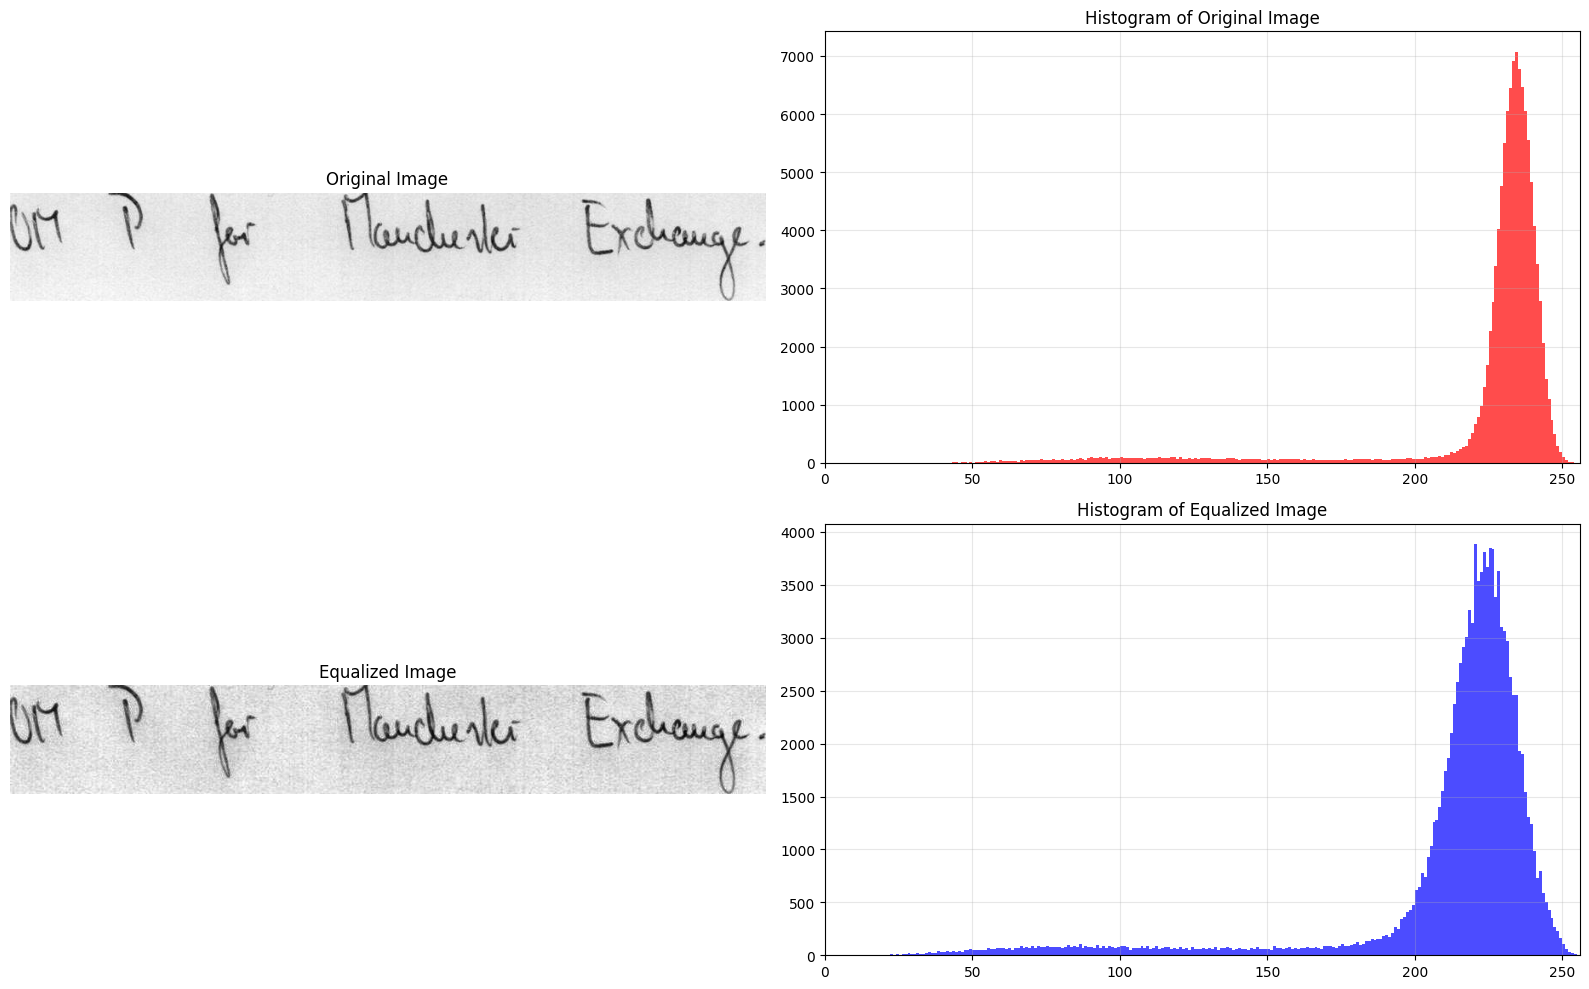

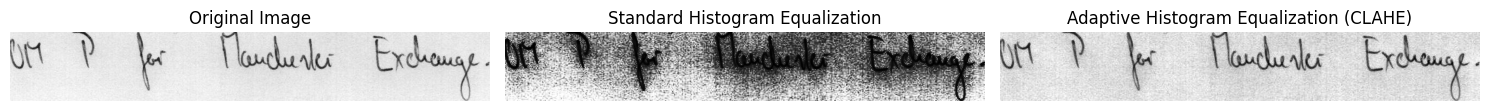

Saved standard equalized image to standard_equalized_image.png
Saved adaptive equalized image to adaptive_equalized_image.png


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def apply_histogram_equalization(image_path, save_path=None, adaptive=False, clip_limit=2.0):
    """
    Apply histogram equalization to enhance image contrast
    
    Args:
        image_path: Path to the input image
        save_path: Path to save the processed image (optional)
        adaptive: Whether to use adaptive histogram equalization (CLAHE)
        clip_limit: Clipping limit for CLAHE (only used if adaptive=True)
        
    Returns:
        The equalized image
    """
    # Check if file exists
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Try different methods to read the image
    try:
        # Read with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("OpenCV couldn't read the image")
    except Exception as e:
        try:
            # Fallback to PIL
            pil_img = Image.open(image_path)
            img = np.array(pil_img)
            # Convert RGB to BGR for OpenCV if needed
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except Exception as e2:
            raise ValueError(f"Could not read image with OpenCV or PIL: {str(e)} | {str(e2)}")
    
    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    if adaptive:
        # Adaptive histogram equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
        equalized = clahe.apply(gray)
    else:
        # Standard histogram equalization
        equalized = cv2.equalizeHist(gray)
    
    # Save the equalized image if a save path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
        cv2.imwrite(save_path, equalized)
    
    return equalized

def display_with_histograms(original_img, equalized_img):
    """
    Display original and equalized images along with their histograms
    """
    plt.figure(figsize=(16, 10))
    
    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    # Histogram of original image
    plt.subplot(2, 2, 2)
    plt.hist(original_img.flatten(), 256, [0, 256], color='r', alpha=0.7)
    plt.title("Histogram of Original Image")
    plt.xlim([0, 256])
    plt.grid(alpha=0.3)
    
    # Equalized image
    plt.subplot(2, 2, 3)
    plt.imshow(equalized_img, cmap='gray')
    plt.title("Equalized Image")
    plt.axis("off")
    
    # Histogram of equalized image
    plt.subplot(2, 2, 4)
    plt.hist(equalized_img.flatten(), 256, [0, 256], color='b', alpha=0.7)
    plt.title("Histogram of Equalized Image")
    plt.xlim([0, 256])
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def batch_process_directory(input_dir, output_dir, adaptive=False, clip_limit=2.0):
    """
    Process all images in a directory with histogram equalization
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            try:
                apply_histogram_equalization(input_path, output_path, adaptive, clip_limit)
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Single image example
    input_path = r"C:\Users\kani1\Desktop\IE643\custom-dataset\iam-handwritten-lines\images\iam_line_0007.png"
    output_path = "equalized_image.png"
    
    try:
        # Read the original image
        original = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
            # Try with PIL if OpenCV fails
            original = np.array(Image.open(input_path).convert('L'))
        
        # Apply standard histogram equalization
        equalized = apply_histogram_equalization(input_path, "standard_" + output_path)
        
        # Apply adaptive histogram equalization (CLAHE)
        adaptive_equalized = apply_histogram_equalization(
            input_path, "adaptive_" + output_path, adaptive=True
        )
        
        # Display comparison with histograms
        display_with_histograms(original, equalized)
        
        # Display adaptive equalization comparison
        display_with_histograms(original, adaptive_equalized)
        
        # Compare standard vs. adaptive
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(equalized, cmap='gray')
        plt.title("Standard Histogram Equalization")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(adaptive_equalized, cmap='gray')
        plt.title("Adaptive Histogram Equalization (CLAHE)")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        print(f"Saved standard equalized image to standard_{output_path}")
        print(f"Saved adaptive equalized image to adaptive_{output_path}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
    
    # Uncomment to process a whole directory
    # input_dir = "path/to/input/images"
    # output_dir = "path/to/output/equalized_images"
    # batch_process_directory(input_dir, output_dir, adaptive=True)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def apply_binarization(image_path, save_path=None, method='otsu', threshold=127, 
                      adaptive_method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, block_size=11, C=2):
    """
    Apply binarization to convert grayscale image to binary image
    
    Args:
        image_path: Path to the input image
        save_path: Path to save the processed image (optional)
        method: Binarization method ('simple', 'otsu', 'adaptive')
        threshold: Threshold value for simple thresholding (0-255)
        adaptive_method: Method for adaptive thresholding
        block_size: Size of pixel neighborhood for adaptive threshold (must be odd)
        C: Constant subtracted from mean or weighted mean (adaptive threshold)
        
    Returns:
        The binarized image
    """
    # Check if file exists
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Try different methods to read the image
    try:
        # Read with OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("OpenCV couldn't read the image")
    except Exception as e:
        try:
            # Fallback to PIL
            pil_img = Image.open(image_path)
            img = np.array(pil_img)
            # Convert RGB to BGR for OpenCV if needed
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except Exception as e2:
            raise ValueError(f"Could not read image with OpenCV or PIL: {str(e)} | {str(e2)}")
    
    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    # Apply binarization based on specified method
    if method == 'simple':
        # Simple thresholding
        _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    elif method == 'otsu':
        # Otsu's thresholding (automatically determines optimal threshold)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'adaptive':
        # Adaptive thresholding
        binary = cv2.adaptiveThreshold(gray, 255, adaptive_method, 
                                      cv2.THRESH_BINARY, block_size, C)
    else:
        raise ValueError(f"Unknown binarization method: {method}")
    
    # Save the binarized image if a save path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
        cv2.imwrite(save_path, binary)
    
    return binary

def display_binarization_comparison(original_img, binary_simple, binary_otsu, binary_adaptive):
    """
    Display comparison of different binarization methods
    """
    plt.figure(figsize=(15, 10))
    
    # Original grayscale image
    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Grayscale Image")
    plt.axis("off")
    
    # Simple thresholding
    plt.subplot(2, 2, 2)
    plt.imshow(binary_simple, cmap='gray')
    plt.title("Simple Thresholding")
    plt.axis("off")
    
    # Otsu's thresholding
    plt.subplot(2, 2, 3)
    plt.imshow(binary_otsu, cmap='gray')
    plt.title("Otsu's Thresholding")
    plt.axis("off")
    
    # Adaptive thresholding
    plt.subplot(2, 2, 4)
    plt.imshow(binary_adaptive, cmap='gray')
    plt.title("Adaptive Thresholding")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def batch_binarize_directory(input_dir, output_dir, method='otsu'):
    """
    Binarize all images in a directory while preserving original filenames
    
    Args:
        input_dir: Directory containing input images
        output_dir: Directory to save binarized images
        method: Binarization method ('simple', 'otsu', 'adaptive')
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            input_path = os.path.join(input_dir, filename)
            # Preserve the exact same filename
            output_path = os.path.join(output_dir, filename)
            
            try:
                apply_binarization(input_path, output_path, method=method)
                print(f"Binarized {filename} → saved as {os.path.basename(output_path)}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Single image example
    input_path = r"C:\Users\kani1\Desktop\IE643\custom-dataset\iam-handwritten-lines\images\iam_line_0007.png"
    
    """try:
        # Read the original image
        original = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
            # Try with PIL if OpenCV fails
            original = np.array(Image.open(input_path).convert('L'))
        
        # Apply different binarization methods
        binary_simple = apply_binarization(input_path, "simple_binary.png", method='simple', threshold=127)
        binary_otsu = apply_binarization(input_path, "otsu_binary.png", method='otsu')
        binary_adaptive = apply_binarization(input_path, "adaptive_binary.png", method='adaptive', 
                                           block_size=15, C=8)
        
        # Display comparisons
        display_binarization_comparison(original, binary_simple, binary_otsu, binary_adaptive)
        
        print("Saved binarized images:")
        print(" - simple_binary.png (simple thresholding)")
        print(" - otsu_binary.png (Otsu's method)")
        print(" - adaptive_binary.png (adaptive thresholding)")
        
    except Exception as e:
        print(f"Error: {str(e)}")"""
    
    # Uncomment to process a whole directory
    input_dir = r"C:\Users\kani1\Desktop\IE643\custom-dataset\iam-handwritten-lines\test\images"
    output_dir = r"C:\Users\kani1\Desktop\IE643\custom-dataset\iam-handwritten-lines\test_binarized"
    batch_binarize_directory(input_dir, output_dir, method='otsu')

Binarized test_line_00000.png → saved as test_line_00000.png
Binarized test_line_00001.png → saved as test_line_00001.png
Binarized test_line_00002.png → saved as test_line_00002.png
Binarized test_line_00003.png → saved as test_line_00003.png
Binarized test_line_00004.png → saved as test_line_00004.png
Binarized test_line_00005.png → saved as test_line_00005.png
Binarized test_line_00006.png → saved as test_line_00006.png
Binarized test_line_00007.png → saved as test_line_00007.png
Binarized test_line_00008.png → saved as test_line_00008.png
Binarized test_line_00009.png → saved as test_line_00009.png
Binarized test_line_00010.png → saved as test_line_00010.png
Binarized test_line_00011.png → saved as test_line_00011.png
Binarized test_line_00012.png → saved as test_line_00012.png
Binarized test_line_00013.png → saved as test_line_00013.png
Binarized test_line_00014.png → saved as test_line_00014.png
Binarized test_line_00015.png → saved as test_line_00015.png
Binarized test_line_0001